# Setup

In [1]:
import os
import sys

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("__file__")))))
PYTHON_CODE_ROOT = os.path.join(PROJECT_ROOT, 'system', 'python')
sys.path.append(PYTHON_CODE_ROOT)
%load_ext autoreload
%autoreload 2

In [2]:
import os
from ais.common.settings import app_settings

# Data

In [33]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=app_settings.DATA_ROOT, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=app_settings.DATA_ROOT, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# EDA

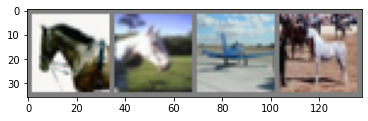

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# Modeling

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = SimpleCNN()

## Loss Function and Optimizer

In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [37]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print stats
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(epoch, i+1, running_loss / 2000)
            running_loss = 0.0
        

0 2000 2.2195000483989715
0 4000 1.8942415588498116
0 6000 1.6800440410673618
0 8000 1.576649633511901
0 10000 1.534788826778531
0 12000 1.4744811282008887
1 2000 1.413551944039762
1 4000 1.3860799714773893
1 6000 1.3660111678391695
1 8000 1.3218431486859918
1 10000 1.2992956997603178
1 12000 1.316799447733909


## Saving model

In [38]:
model_path = f'{app_settings.MODELS_ROOT}/alexnet_cifar10_net.pth'
torch.save(net.state_dict(), model_path)

# Evaluation

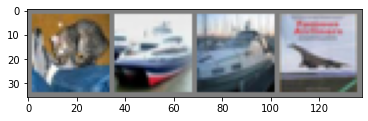

ground truth ['cat', 'ship', 'ship', 'plane']


In [39]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('ground truth', [classes[l] for l in labels])

In [40]:
net = SimpleCNN()
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [41]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('predicted', [classes[p] for p in predicted])

predicted ['cat', 'ship', 'ship', 'plane']


In [42]:
correct = 0
total = 0
# Switch off gradient calculations (used only in training)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total)}')


Accuracy of the network on the 10000 test images: 55.01


In [43]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname:5s} is: {accuracy:.1f}")


Accuracy for class plane is: 69.2
Accuracy for class car   is: 59.5
Accuracy for class bird  is: 37.3
Accuracy for class cat   is: 28.6
Accuracy for class deer  is: 44.7
Accuracy for class dog   is: 51.6
Accuracy for class frog  is: 69.0
Accuracy for class horse is: 56.9
Accuracy for class ship  is: 64.3
Accuracy for class truck is: 69.0


# Training on GPU

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# References
Source: 
- AlexNet https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html